In [ ]:
# Embeddings from scratch - building word2vec

In [153]:
# from here: https://en.wikipedia.org/wiki/Music
text = """Music is the arrangement of sound to create some combination of form, harmony, melody, rhythm, or otherwise expressive content. Music is generally agreed to be a cultural universal that is present in all human societies. Definitions of music vary widely in substance and approach. While scholars agree that music is defined by a small number of specific elements, there is no consensus as to what these necessary elements are. Music is often characterized as a highly versatile medium for expressing human creativity. Diverse activities are involved in the creation of music, and are often divided into categories of composition, improvisation, and performance. Music may be performed using a wide variety of musical instruments, including the human voice. It can also be composed, sequenced, or otherwise produced to be indirectly played mechanically or electronically, such as via a music box, barrel organ, or digital audio workstation software on a computer."""

In [154]:
import re

def tokenize(text):
    text = text.lower().replace('.', '').replace(',', '').split(' ')
    return text

In [155]:
tokens = tokenize(text)

In [156]:
def map_tokens(tokens):
    token_to_id = {}
    id_to_token = {}
    unique_tokens = sorted(set(tokens))

    for i, token in enumerate(unique_tokens):
        token_to_id[token] = i
        id_to_token[i] = token
    

    return token_to_id, id_to_token

In [157]:
token_to_id, id_to_token = map_tokens(tokens)

In [158]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [159]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [160]:
# !pip install numpy

In [161]:
import numpy as np
# TODO rewrite this function in a more intuitive way ... without iterables
def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)
        

In [162]:
X, y = generate_training_data(tokens, token_to_id, 2)

In [163]:
def initialise_model(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [164]:
model = initialise_model(len(token_to_id), 10)

In [165]:
def forward(model, X, return_cache=True):
    cache = {}

    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])

    if not return_cache:
        return cache["z"]
    return cache

In [166]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [167]:
def backward(model, X, y, lr):
    cache = forward(model, X)
    da2 = cache["z"] - y  # predicted minus actual
    dw2 = cache["a1"].T @ da2  # 
    da1 = da2 @ model["w2"].T  # 
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= lr * dw1
    model["w2"] -= lr * dw2
    return cross_entropy(cache["z"], y)

In [168]:
def cross_entropy(z, y):
    return -np.sum(y * np.log(z))

In [169]:
!pip install matplotlib

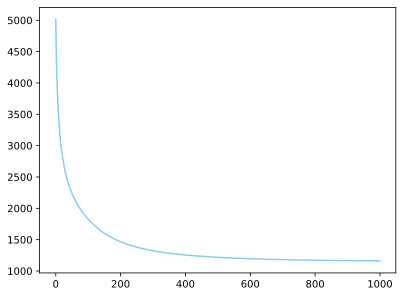

In [170]:
import matplotlib.pyplot as plt
n_iter = 1000
learning_rate = 0.005

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]
plt.plot(range(len(history)), history, color="skyblue")
plt.show()